In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, AdamW, RAdam, LBFGS
from torch.nn.parameter import Parameter
from torch.nn import NLLLoss, BCEWithLogitsLoss
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout2d, Linear, Dropout
from torch import cat
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from datetime import datetime
import pprint

d:\miniconda3\Lib\site-packages\pennylane\__init__.py:196: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.0 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        ])


train_ds = torchvision.datasets.FashionMNIST(
    "./", train=True, download=True,
    transform=transform)

test_ds = torchvision.datasets.FashionMNIST(
    "./", train=False, download=True,
    transform=transform)


train_mask = (train_ds.targets == 0) | (train_ds.targets == 6)
train_idx = torch.where(train_mask)[0]
train_ds.targets[train_ds.targets == 6] = 1

batch_size = 40

binary_train_ds = Subset(train_ds, train_idx)
train_loader = DataLoader(binary_train_ds, batch_size = batch_size, shuffle =True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [3]:
torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 8, kernel_size=5, padding=2)
        self.conv2 = Conv2d(8, 25, kernel_size=5, padding=2)
        self.dropout = Dropout2d()
        self.fc1 = Linear(25 * 7 * 7, 36)
        self.fn_dropout = Dropout(p=0.05)
        self.fc2 = Linear(36, 2)
        self.fc3 = Linear(2, 1)

        # Quantum layer
        self.num_q_wires = 2
        self.q_device = qml.device("default.qubit", wires=self.num_q_wires)
        
        self.num_q_layers = 2
        qnn_params_size = (self.num_q_layers * 3 + 2) * self.num_q_wires
        qnn_params_tensor = torch.empty(qnn_params_size, requires_grad=True)

        # Kaiming 초기화의 gain 값 계산 (SiLU에 적합한 'leaky_relu'를 사용)
        gain = torch.nn.init.calculate_gain('leaky_relu')
        std = gain / qnn_params_size**0.5 # 텐서 크기를 이용한 표준 편차 계산
        
        # 균등 분포로 파라미터 초기화
        torch.nn.init.uniform_(qnn_params_tensor, -std, std)

        self.qnn_params = Parameter(qnn_params_tensor)

        #@qml.qnode(self.q_device)
        @qml.qnode(self.q_device, interface="torch")
        def circuit(x_batch):
            param_idx = 0 
            for layer in range(self.num_q_layers): # num_q_layers 만큼 반복
                for i in range(self.num_q_wires):
                    qml.H(wires=i)
                    qml.RZ(2. * x_batch[:, i], wires=i)
                    
                for i in range(self.num_q_wires):
                    qml.CRZ(2. * (torch.pi - x_batch[:, i]) * (torch.pi - x_batch[:, (i+1) % self.num_q_wires]), wires=[i, (i+1)%self.num_q_wires])

                # EfficientSU2
                for i in range(self.num_q_wires):
                    qml.RY(self.qnn_params[param_idx], wires=i)
                    param_idx += 1
                    qml.RX(self.qnn_params[param_idx], wires=i)
                    param_idx += 1
                    #qml.Rot(self.qnn_params[param_idx], self.qnn_params[param_idx+1], torch.tensor(-torch.pi/2, dtype=torch.float64), wires=i)
                    #param_idx += 2
                    qml.Y(wires=i)

                for i in range(self.num_q_wires):
                    qml.CRX(self.qnn_params[param_idx], wires=[i, (i+1)%self.num_q_wires])
                    param_idx += 1
                    #qml.CNOT(wires=[i, (i+1)%self.num_q_wires])

                
                if layer == self.num_q_layers-1:
                    for i in range(self.num_q_wires):
                        qml.RY(self.qnn_params[param_idx], wires=i)
                        param_idx += 1
                        qml.RX(self.qnn_params[param_idx], wires=i)
                        param_idx += 1
                        #qml.Rot(self.qnn_params[param_idx], self.qnn_params[param_idx+1], torch.tensor(-torch.pi/2, dtype=torch.float64), wires=i)
                        #param_idx += 2
                        qml.Y(wires=i)
            
            #return qml.expval(self.obs) # qml.expval은 이제 (BATCH_SIZE,) 형태를 반환
            return [qml.expval(qml.PauliZ(i)) for i in range(self.num_q_wires)]

        self.qnn = circuit

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.leaky_relu(self.fc1(x))
        #x = F.dropout(x, p=0.1)
        x = self.fn_dropout(x)

        x = self.fc2(x)
        
        #x = self.qnn(x).view(1,)  # apply QNN
        qnn_out = self.qnn(x) 
        x = torch.stack(qnn_out, dim=-1).to(x.device)
        
        x = self.fc3(x)
        return F.log_softmax(cat((x, 1 - x), -1), -1)


    # BinaryClassifier 클래스 내부에 추가
    def forward_classical(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x, p=0.1)
        x = self.fc2(x)
        return x

bc = BinaryClassifier()
bc.to(device)

BinaryClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1225, out_features=36, bias=True)
  (fn_dropout): Dropout(p=0.05, inplace=False)
  (fc2): Linear(in_features=36, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=1, bias=True)
)

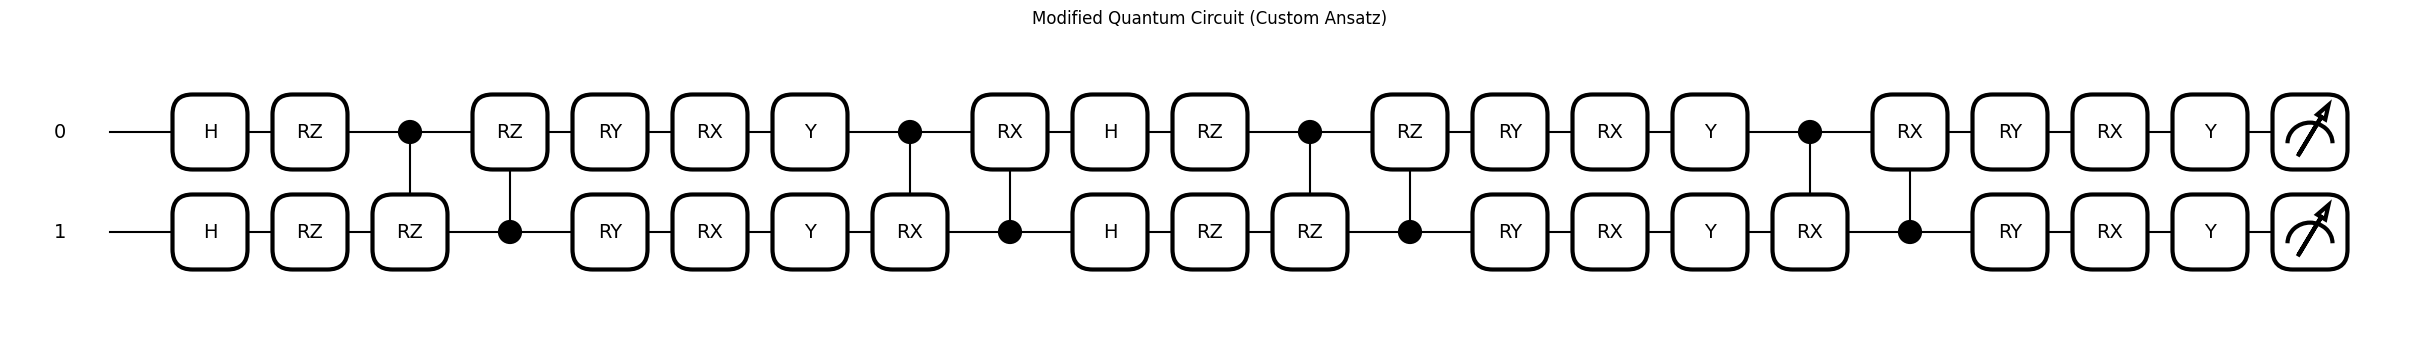

In [4]:
dummy_x = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=torch.float64).to(device)
specs = qml.specs(bc.qnn)(dummy_x)
total_params = sum(p.numel() for p in bc.parameters() if p.requires_grad)

# 양자 회로 그리기
fig, ax = qml.draw_mpl(bc.qnn)(dummy_x)
plt.title("Modified Quantum Circuit (Custom Ansatz)")
plt.show()

In [5]:
pprint.pprint(specs, width=1)
print(total_params)
assert specs["num_tape_wires"] <= 8,  "❌ 큐빗 수 초과"
assert specs['resources'].depth <= 30, "❌ 회로 깊이 초과"
assert specs["num_trainable_params"]<= 60, "❌ 학습 퀀텀 파라미터 수 초과"
assert total_params <= 50000, "❌ 학습 전체 파라미터 수 초과"

print("✅ 회로 제약 통과 — 학습을 계속합니다")

{'device_name': 'default.qubit',
 'diff_method': 'best',
 'errors': {},
 'gradient_fn': 'backprop',
 'gradient_options': {},
 'interface': 'torch',
 'level': 'gradient',
 'num_device_wires': 2,
 'num_observables': 2,
 'num_tape_wires': 2,
 'num_trainable_params': 16,
 'resources': Resources(num_wires=2,
                        num_gates=34,
                        gate_types=defaultdict(<class 'int'>,
                                               {'CRX': 4,
                                                'CRZ': 4,
                                                'Hadamard': 4,
                                                'PauliY': 6,
                                                'RX': 6,
                                                'RY': 6,
                                                'RZ': 4}),
                        gate_sizes=defaultdict(<class 'int'>,
                                               {1: 26,
                                                2: 8}),
         

In [6]:
def train_step(epochs, lr=0.0010, weight_decay=1e-6):
    # 1. 고전 신경망 파라미터와 양자 신경망 파라미터 분리
    classical_params = [
        p for n, p in bc.named_parameters() if 'qnn_params' not in n
    ]
    qnn_params = [
        p for n, p in bc.named_parameters() if 'qnn_params' in n
    ]

    # 2. 고전 신경망을 위한 옵티마이저
    classical_optimizer = AdamW(classical_params, lr=lr, weight_decay=weight_decay)

    # 3. 양자 신경망을 위한 옵티마이저 (학습률 감소)
    qnn_optimizer = LBFGS(qnn_params, lr=lr)

    # 스케줄러 (여기서는 고전 옵티마이저에만 적용)
    scheduler = CosineAnnealingLR(classical_optimizer, T_max=epochs * len(train_loader), eta_min=1e-6)

    loss_history = []
    bc.train()

    print(f"Starting split training on {device}...")
    for epoch in range(epochs):
        total_loss = []
        
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            data = data.to(device)
            target = target.to(device).flatten().long()


            # 1. 고전 신경망 부분 학습
            classical_optimizer.zero_grad(set_to_none=True)
            output = bc(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            classical_optimizer.step()

            # 2. 양자 신경망 부분 학습
            def closure():
            # LBFGS는 closure 함수 내에서 zero_grad를 호출해야 합니다.
                qnn_optimizer.zero_grad()
                
                # 여기서 bc(data)를 다시 호출하여 새로운 순전파를 수행합니다.
                output_qnn_step = bc(data.detach())
                loss_qnn_step = F.nll_loss(output_qnn_step, target)
                loss_qnn_step.backward()
                
                return loss_qnn_step

            qnn_optimizer.step(closure)
            #qnn_optimizer.zero_grad(set_to_none=True)
            # 여기서는 손실을 다시 계산하여 qnn_params에 대한 기울기를 업데이트
            #output_qnn_step = bc(data.detach())
            #loss_qnn_step = F.nll_loss(output_qnn_step, target)
            #loss_qnn_step.backward()
            #qnn_optimizer.step()



            scheduler.step()
            total_loss.append(loss.item())
        
        avg_loss = sum(total_loss) / len(total_loss)
        loss_history.append(avg_loss)
        print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] Loss: {avg_loss:.4f}")

    return loss_history

In [7]:
def test():
    print(f"Starting inference on {device}...")
    bc.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in tqdm(test_loader,
                                desc="Inference",
                                total=len(test_loader),
                                leave=False):
            data, target = data.to(device), target.to(device).flatten().long() #target.to(device).float().unsqueeze(1)

            logits = bc(data)

            pred = logits.argmax(dim=-1)
            #probabilities = torch.sigmoid(logits)
            #pred = (probabilities >= 0.5).float().squeeze(1) 

            all_preds.append(pred.cpu())
            all_targets.append(target.cpu())

    y_pred = torch.cat(all_preds).numpy().astype(int)
    y_true = torch.cat(all_targets).numpy().astype(int)

    #y_pred = torch.cat(all_preds).numpy().flatten().astype(int) # .flatten() 추가
    #y_true = torch.cat(all_targets).numpy().flatten().astype(int) # .flatten() 추가

    # --- 8. 평가 및 결과 저장 ---
    # 베이스라인 평가 로직을 따릅니다. y_true는 이제 10000개 길이를 가집니다.
    test_mask = (y_true == 0) | (y_true == 6)

    print("total samples:", len(y_true))
    print("target samples:", test_mask.sum())

    # 모델 결과가 1인 것을 6으로 변경 (제출 형식에 맞게)
    y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

    # 정확도 계산은 0/6 라벨에 대해서만 수행
    acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
    print(f"accuracy (labels 0/6 only): {acc:.4f}")

    now = datetime.now().strftime("%Y%m%d_%H%M%S")

    y_pred_filename = f"y_pred_{now}.csv"

    return y_pred_mapped, y_pred_filename, acc



In [8]:
def plt_loss_history(loss_history, n_repeats, epochs_per_repeat):
    """
    학습 손실 이력을 시각화합니다.
    Args:
        loss_history (list): 에포크별 평균 손실 값 리스트
        n_repeats (int): train_step 함수의 총 반복 횟수 (n)
        epochs_per_repeat (int): 한 번의 train_step에서 에포크 수 (epochs)
    """
    total_epochs = n_repeats * epochs_per_repeat
    x_axis = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, loss_history)
    plt.title("Training Loss History")
    plt.xlabel("Total Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# 사용 예시
# loss_history는 모든 반복(n)과 에포크(epochs)의 손실이 담긴 리스트
# loss_history = [ ... ]

# plt_loss_history(loss_history, n_repeats=15, epochs_per_repeat=20)

In [9]:
result = 0
best_result = 0
max_y_pred_filename = ""
best_n = 0
n = 0
epochs = 10
lr = 0.0015
loss_history = []

while result < 0.92:
    lr = 0.0015 * (0.80**n)
    loss_history.extend(train_step(epochs=epochs, lr=lr, weight_decay=batch_size * 1e-6))
    y_pred_mapped, y_pred_filename, result = test()
    print(f"Iteration {n+1}: Result = {result:.4f}")

    if result > best_result:
        best_result = result
        best_n = n
        max_y_pred_filename = y_pred_filename

    n += 1

Starting split training on cuda...


Epoch 1/10: 100%|██████████| 300/300 [00:42<00:00,  7.14it/s]


Training [10%] Loss: 0.4744


Epoch 2/10: 100%|██████████| 300/300 [00:39<00:00,  7.50it/s]


Training [20%] Loss: 0.3748


Epoch 3/10: 100%|██████████| 300/300 [00:34<00:00,  8.61it/s]


Training [30%] Loss: 0.3305


Epoch 4/10: 100%|██████████| 300/300 [00:31<00:00,  9.61it/s]


Training [40%] Loss: 0.3061


Epoch 5/10: 100%|██████████| 300/300 [00:31<00:00,  9.65it/s]


Training [50%] Loss: 0.2899


Epoch 6/10: 100%|██████████| 300/300 [00:31<00:00,  9.51it/s]


Training [60%] Loss: 0.2724


Epoch 7/10: 100%|██████████| 300/300 [00:34<00:00,  8.64it/s]


Training [70%] Loss: 0.2554


Epoch 8/10: 100%|██████████| 300/300 [00:40<00:00,  7.38it/s]


Training [80%] Loss: 0.2435


Epoch 9/10: 100%|██████████| 300/300 [00:40<00:00,  7.39it/s]


Training [90%] Loss: 0.2417


Epoch 10/10: 100%|██████████| 300/300 [00:41<00:00,  7.23it/s]


Training [100%] Loss: 0.2357
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8795
Iteration 1: Result = 0.8795
Starting split training on cuda...


Epoch 1/10: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


Training [10%] Loss: 0.2620


Epoch 2/10: 100%|██████████| 300/300 [00:47<00:00,  6.26it/s]


Training [20%] Loss: 0.2529


Epoch 3/10: 100%|██████████| 300/300 [00:47<00:00,  6.27it/s]


Training [30%] Loss: 0.2421


Epoch 4/10: 100%|██████████| 300/300 [00:35<00:00,  8.41it/s]


Training [40%] Loss: 0.2339


Epoch 5/10: 100%|██████████| 300/300 [00:35<00:00,  8.46it/s]


Training [50%] Loss: 0.2244


Epoch 6/10: 100%|██████████| 300/300 [00:37<00:00,  7.90it/s]


Training [60%] Loss: 0.2045


Epoch 7/10: 100%|██████████| 300/300 [00:36<00:00,  8.17it/s]


Training [70%] Loss: 0.1990


Epoch 8/10: 100%|██████████| 300/300 [00:41<00:00,  7.29it/s]


Training [80%] Loss: 0.1895


Epoch 9/10: 100%|██████████| 300/300 [00:46<00:00,  6.50it/s]


Training [90%] Loss: 0.1835


Epoch 10/10: 100%|██████████| 300/300 [00:46<00:00,  6.42it/s]


Training [100%] Loss: 0.1819
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8880
Iteration 2: Result = 0.8880
Starting split training on cuda...


Epoch 1/10: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s]


Training [10%] Loss: 0.2123


Epoch 2/10: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]


Training [20%] Loss: 0.2065


Epoch 3/10: 100%|██████████| 300/300 [00:39<00:00,  7.57it/s]


Training [30%] Loss: 0.2002


Epoch 4/10: 100%|██████████| 300/300 [00:39<00:00,  7.63it/s]


Training [40%] Loss: 0.1894


Epoch 5/10: 100%|██████████| 300/300 [00:39<00:00,  7.63it/s]


Training [50%] Loss: 0.1844


Epoch 6/10: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]


Training [60%] Loss: 0.1662


Epoch 7/10: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]


Training [70%] Loss: 0.1577


Epoch 8/10: 100%|██████████| 300/300 [00:43<00:00,  6.91it/s]


Training [80%] Loss: 0.1556


Epoch 9/10: 100%|██████████| 300/300 [00:43<00:00,  6.97it/s]


Training [90%] Loss: 0.1526


Epoch 10/10: 100%|██████████| 300/300 [00:43<00:00,  6.92it/s]


Training [100%] Loss: 0.1478
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8890
Iteration 3: Result = 0.8890
Starting split training on cuda...


Epoch 1/10: 100%|██████████| 300/300 [00:40<00:00,  7.46it/s]


Training [10%] Loss: 0.1734


Epoch 2/10: 100%|██████████| 300/300 [00:40<00:00,  7.36it/s]


Training [20%] Loss: 0.1719


Epoch 3/10: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]


Training [30%] Loss: 0.1659


Epoch 4/10: 100%|██████████| 300/300 [00:41<00:00,  7.25it/s]


Training [40%] Loss: 0.1565


Epoch 5/10: 100%|██████████| 300/300 [00:42<00:00,  7.03it/s]


Training [50%] Loss: 0.1476


Epoch 6/10:   8%|▊         | 25/300 [00:03<00:39,  7.01it/s]


KeyboardInterrupt: 

In [11]:
#plt_loss_history(loss_history, n, epochs)
print(f"Best result: {best_result:.4f} at iteration {best_n}")
# 전체 10000개 샘플에 대한 예측을 저장 (대회 제출 형식)
np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")
print(f"Prediction saved to {max_y_pred_filename}")

Best result: 0.8930 at iteration 15
Prediction saved to y_pred_20250805_032755.csv
